# Experiment Tracking with MLFlow (Local)

In this demo we will see how to use MLFlow for tracking experiments, using a toy data set. In the attached lab (below), you will download a larger dataset and attempt to train the best model that you can.

We should first install mlflow, and add it to the requirements.txt file if not done already.

`pip install mlflow` or `python3 -m pip install mlflow`.

You may also need to `pip install setuptools`.

From here, make sure to save this notebook in a specific folder, and ensure you run all command line commands from the same folder.

In [4]:
!pip install mlflow 
# !pip install setuptools

  Using cached flask-3.1.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached graphene-3.4.3-py2.py3-none-any.whl.metadata (6.9 kB)
  Using cached gunicorn-23.0.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached pyarrow-19.0.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (3.3 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached fastapi-0.115.12-py3-none-any.whl.metadata (27 kB)
  Using cached protobuf-5.29.4-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached sqlparse-0.5.3-py3-none-any.whl.metadata (3.9 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached graphql_core-3.2.6-py3-none-any.whl.metadata (11 kB)
  Using cached graphql_relay-3.2.0-py

In [2]:
# !pip install --quiet mlflow setuptools

In [5]:
import mlflow
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

After loading the libraries, we can first check the mlflow version you have. And, just for fun, let's look at the mlflow UI by running `mlflow ui`. After this, we should do two things:
- set the tracking uri
- create or set the experiment

Setting the tracking uri tells mlflow where to save the results of our experiments. We will first save these locally in a sqlite instance. In a future lab we will set up mlflow to run in GCP.

If you've already created an experiment previously that you'd like to use, you can tell mlflow by setting the experiment. You can also use `set_experiment` even if the experiment has not yet been created - mlflow will first check if the experiment exists, and if not, it will create it for you. 

In [6]:
mlflow.__version__

'2.21.3'

Running the below code will create a sqlite database and an mlruns folder in the current directory.

In [7]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('demo-experiment')

2025/04/14 22:48:37 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/815198488629088057', creation_time=1744696117850, experiment_id='815198488629088057', last_update_time=1744696117850, lifecycle_stage='active', name='demo-experiment', tags={}>

From here, we can load the wine data from sklearn and take a look at it. Then let's play around with some models, without using mlflow for now, to get a sense of why mlflow might come in handy.

In [8]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [9]:
y = wine.target
X = df_wine
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [10]:
accuracy_score(y, dt.predict(df_wine))

0.9887640449438202

## Train a Model Using MLFLow

In this section, let's train a simple decision tree model, where we will now adjust the maximum depth (`max_depth`) of the tree, and save the results of each run of the experiment using mlflow. To do so, we need to tell mlflow to start recording. We do this with `start_run`. 

The things we might want to record in this simple case are:
- the value of `max_depth`
- the corresponding accuracy of the model

We can also tag each run to make it easier to identify them later.

After running the below code, be sure to check the mlflow UI by running the following in the terminal from the same directory as where you saved this notebook:

`mlflow ui` note that just running this you will not see any of your experiments. You must specify the uri (the place where all of your results are being stored)

`mlflow ui --backend-store-uri sqlite:///mlflow.db`

In [11]:
mlflow.end_run()
with mlflow.start_run():
    # log parameters and log metrics
    # parameters: hyperparameters
    # metrics: model performance metrics

    mlflow.set_tags({"Model":"decision-tree", "Train Data": "all-data"})

    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X, y)
    acc = accuracy_score(y, dt.predict(df_wine))

    mlflow.log_param("max_depth", tree_depth)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

🏃 View run rare-sponge-284 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/c7c02db711bb4ab293a151b429faf8cb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057


Let's do it again, but this time we'll use a random forest, which has some other hyperparameters we can tune, which makes keeping track of things a little more complex without a tool like mlflow.

In [12]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

    ntree = 1000
    mtry = 4

    mlflow.log_params({'n_estimators':ntree, 'max_features':mtry})

    rf = RandomForestClassifier(n_estimators = ntree, max_features = mtry, oob_score = True)
    rf.fit(X,y)
    acc = rf.oob_score_
    #acc = accuracy_score(y, rf.predict(X))
    mlflow.log_metric('accuracy', acc)

mlflow.end_run()

🏃 View run clumsy-mole-778 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/e81758d2c1af4eef83165ffac95e7a65
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057


Typically, in a real-world scenario, you wouldn't change your parameter values manually and re-run your code, you would either use a loop to loop through different parameter values, or you'd use a built-in method for doing cross-validation, of which there are a few. First, let's use a simple loop to run the experiment multiple times, and save the results of each run.

In [13]:
ntrees = [20,40,60,80,100]
mtrys = [3,4,5]
for i in ntrees:
    for j in mtrys:
        with mlflow.start_run():
            mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

            mlflow.log_params({'n_estimators':i, 'max_features':j})

            rf = RandomForestClassifier(n_estimators = i, max_features = j, oob_score = True)
            rf.fit(X,y)
            acc = rf.oob_score_
            #acc = accuracy_score(y, rf.predict(X))
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

🏃 View run exultant-fawn-449 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/7e94c7c8ede44780944839aecd4be344
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057
🏃 View run nervous-stork-950 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/7231f4d4d9034f088b5165009265a5ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057
🏃 View run intrigued-dove-237 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/818489baf05247d59c0de93e8fe950e9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057
🏃 View run invincible-carp-361 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/c32e9a2c8a2643a89ce9e5d79390dcd0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057
🏃 View run clumsy-newt-510 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/e847d49136f84664a8d0f0b0212e3f88
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815

## Training a Model with mlflow and hyperopt

One way of tuning your model is to use the `hyperopt` library. `hyperopt` is a library that does hyperparameter tuning, and does so in a way that makes it easy for mlflow to keep track of the results. 

First, install the libraries you don't have, and then load them below. We do not use `hyperopt` much in the class, so if you don't want to add it to your requirements.txt file, you don't have to.

For this exercise, we'll split the data into training and validation, and then we'll train decision trees and random forests and use `hyperopt` to do the hyperparameter tuning and find the best model for us.

In [14]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)


In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

From the above we will use `cross_val_score` for our metric, `fmin` is used by `hyperopt` to do the tuning, `tpe` (Tree of Parzen Estimators) is the algorithm used to search the hyperparameter space,  `hp` has methods we need to use for defining our search space, `STATUS_OK` is a status message that each run completed, and `Trials` keeps track of each run.

In [16]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}

search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()

In [17]:
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

🏃 View run powerful-crab-709 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/6e8b26effdaa4f619a033c15386beea4

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057

🏃 View run peaceful-crab-784 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/830434e33a5646efbdcc1f9bab012b44

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057    

🏃 View run mercurial-fox-278 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/50f7fc446ac5457ab3cbc3b270adb13e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057    

🏃 View run intelligent-pug-515 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/87fa568b6ea04003aedcb649ad7a6ae2

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057    

🏃 View run enchanting-moose-661 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/13d4588895114b09964086b810f077e7

🧪 View experiment at: http://127.0.0

In [18]:
best_result

{'classifier_type': np.int64(1),
 'criterion': np.int64(0),
 'rf_max_features': np.int64(3),
 'rf_n_estimators': np.int64(211)}

### Using Autologging

Rather than manually logging parameters and metrics, mlflow has an autolog feature, which is compatible with a subset of python libraries, such as sklearn. Autologging makes it easy to log all of the important stuff, without having to manually write lines of code to log the parameters. However, sometimes you will want to have finer control over what gets logged, and should instead skip autologging.

In [19]:
with mlflow.start_run():
    mlflow.sklearn.autolog()
    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X_train, y_train)
    mlflow.sklearn.autolog(disable=True)
mlflow.end_run()

🏃 View run abundant-cow-981 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/85ab6e8a17de4bc59c8f14de34c339df
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057


# Artifact Tracking and Model Registry (Local)

In this section we will save some artifacts from our model as we go through the model development process. There are a few things that might be worth saving, such as datasets, plots, and the final model itself that might go into production later.

## Data

First, let's see how we can store our important datasets, in a compressed format, for use for later, for example, in case we get a new request about our model and need to run some analyses (such as "what is the distribution of this feature, but only for this specific subset of data?" or "how did the model do on these particular observations from your validation set?").

In [20]:
import os 

os.makedirs('save_data', exist_ok = True)

X_train.to_parquet('save_data/x_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')

In [21]:
X_test.to_parquet('save_data/x_test.parquet')

mlflow.log_artifacts('save_data/')

You can now go to the mlflow UI, click on the latest run, and select the Artifacts tab. You should see something similar to this:
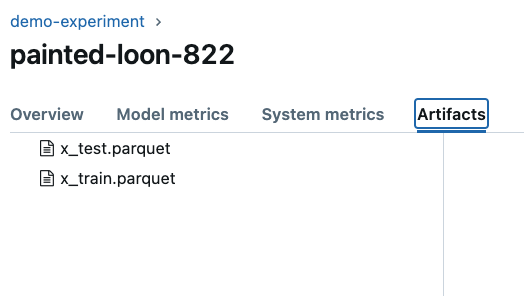

## Images

As part of the model dev process you may end up creating visualizations that can be useful for analysis, or for reporting. You can use mlflow to log the important ones and ignore the rest. After creating the below figure, save into a folder called images, and then you can log whatever is in the `images` folder as an artifact.

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

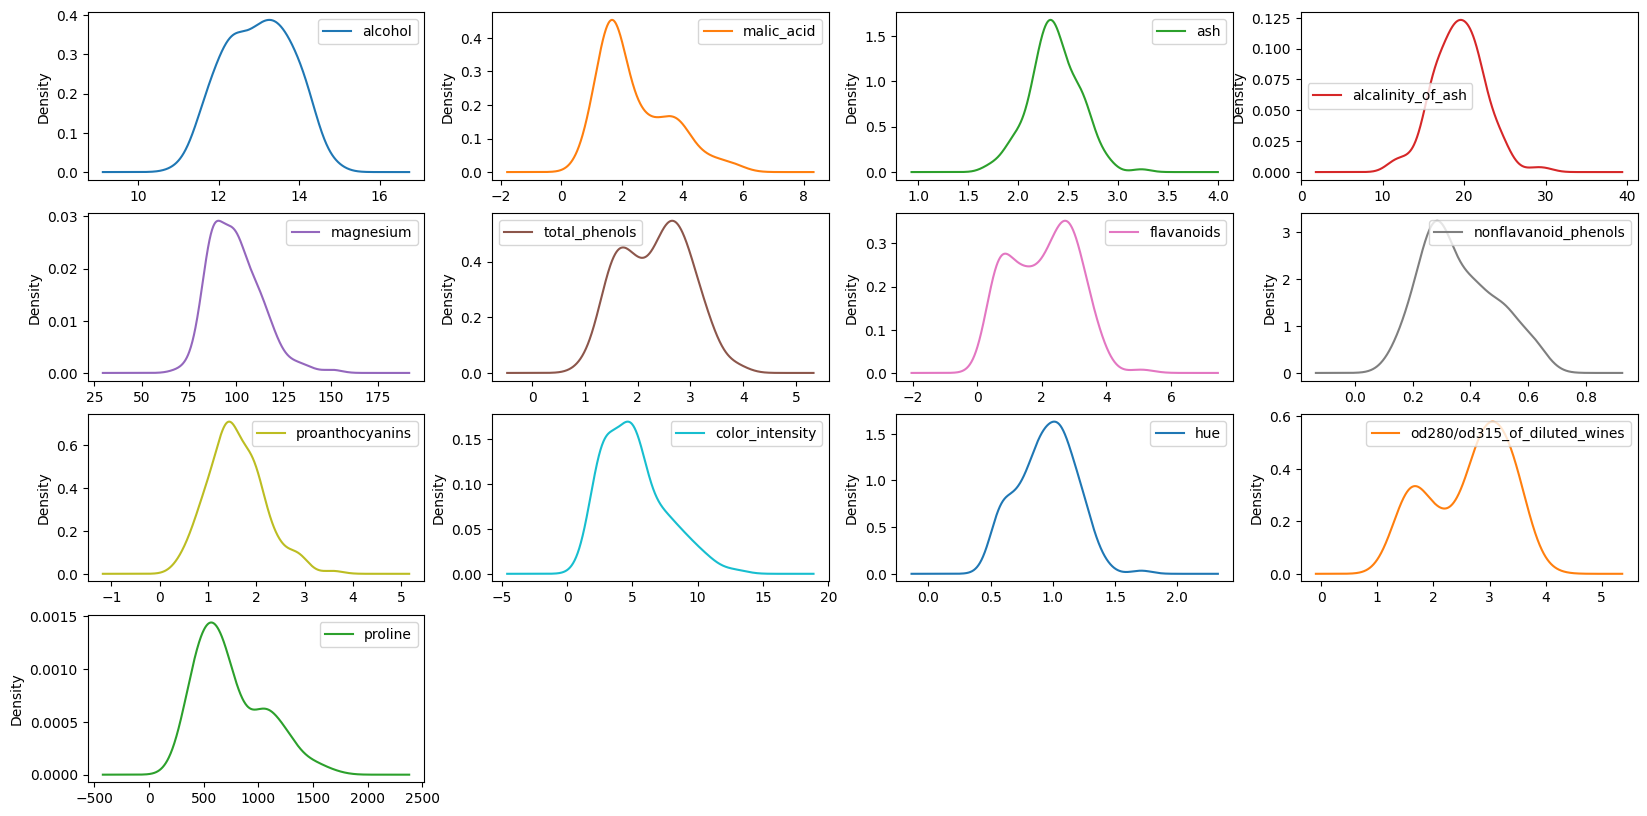

In [22]:
%matplotlib inline
os.makedirs('images', exist_ok = True)
X_train.plot.density(subplots = True, figsize = (20,10), layout = (4,4), sharey = False, sharex = False)

In [23]:
mlflow.log_artifacts('images')
mlflow.end_run()

🏃 View run exultant-conch-33 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/ef0aba2881724577a994a3f2d7727c84
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057


Notice how all of the artifacts were saved in the same run of the experiment. We could have added an `mlflow.end_run()` in between our `log_artifacts` lines to separate runs if we wanted to.

## Model Management and Model Registry

As you are developing your models you may want to save certain versions of the model, or maybe even all of them, so that you don't have to go back and retrain them later. We can do this in mlflow by logging the models, not as artifacts, but as models, using `log_model`. 

In this section we'll log a couple of models to see how mlflow handles model management. Above, we used `hyperopt` to train a bunch of models at once. Let's do this again, and log some of the models that we train.

### Logging as an Artifact

First we can try logging a model as an artifact. To do this, we must first save the model itself, which we can do by using the `pickle` library. We then log the model as an artifact like we did with data and images. 

In [24]:
import pickle

os.makedirs('../models', exist_ok = True)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

with open('../models/model.pkl','wb') as f:
    pickle.dump(dt,f)

# First we'll log the model as an artifact
mlflow.log_artifact('../models/model.pkl', artifact_path='my_models')

### Logging as a Model

Logging the model as an artifact only logs the pickle file (the serialized version of the model). It's not really very useful, especially since models contain so much metadata that might be critical to know for deploying the model later. mlflow has a built-in way of logging models specifically, so let's see how to use this, and how it's different from logging models as an artifact.

In [25]:
# Let's do it again, but this time we will log the model using log_model
mlflow.sklearn.log_model(dt, artifact_path = 'better_models')
mlflow.end_run()

2025/04/14 22:49:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run glamorous-shrimp-740 at: http://127.0.0.1:5000/#/experiments/815198488629088057/runs/89b9a9fda61443b4bf43154370c16a90
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815198488629088057


Ok, so if you go to the mlflow UI at this point you can see the difference in `log_artifact`, which simply logs the pickle file, and `log_model`, which also gives you information about the environment, required packages, and model flavor.

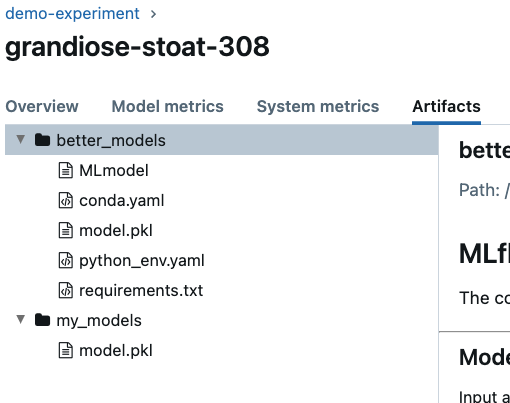

Let's do this one more time, but this time let's use `hyperopt` and log all of the trained models separately. Let's do this in a new experiment called 'demo-experiment2'. 

In [26]:
mlflow.set_experiment('demo-experiment2')
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, artifact_path = 'better_models')
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}
search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

2025/04/14 22:49:22 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment2' does not exist. Creating a new experiment.


  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/04/14 22:49:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run luxuriant-grouse-225 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/ef624ba03f644ad698fc1e8218fc0343

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376

  3%|▎         | 1/32 [00:03<01:53,  3.67s/trial, best loss: -0.9609523809523809]

2025/04/14 22:49:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run tasteful-auk-524 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/65702215529447ebb426c45699b4b52c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376    

  6%|▋         | 2/32 [00:05<01:17,  2.59s/trial, best loss: -0.9609523809523809]

2025/04/14 22:49:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run serious-foal-144 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/8ee010cf8205445c8221e2e5bdf44a65

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376    

  9%|▉         | 3/32 [00:07<01:04,  2.22s/trial, best loss: -0.9609523809523809]

2025/04/14 22:49:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run sassy-cow-569 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/a44b13ed569b4f938aaff5d3856ad5ad

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376    

 12%|█▎        | 4/32 [00:09<00:58,  2.08s/trial, best loss: -0.9609523809523809]

2025/04/14 22:49:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run ambitious-moose-394 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/d6c238fcab464ff8bb302bd39b1cc5a5

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376    

 16%|█▌        | 5/32 [00:11<00:56,  2.09s/trial, best loss: -0.9609523809523809]

2025/04/14 22:49:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run powerful-quail-969 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/5c9788ea4f2e4a21bf062eba15445d4b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376    

 19%|█▉        | 6/32 [00:13<00:59,  2.29s/trial, best loss: -0.9609523809523809]

2025/04/14 22:49:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run unique-bug-295 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/c312f554ad784d329dd665f89ca273c7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376    

 22%|██▏       | 7/32 [00:16<00:55,  2.23s/trial, best loss: -0.9609523809523809]

2025/04/14 22:49:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run incongruous-pug-357 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/cb681a68d62043a68d67e447da8d5b9c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376    

 25%|██▌       | 8/32 [00:18<00:55,  2.31s/trial, best loss: -0.9609523809523809]

2025/04/14 22:49:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run painted-trout-829 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/1d468b6d827843a2b83767eb7fa6b252

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376    

 28%|██▊       | 9/32 [00:21<01:01,  2.65s/trial, best loss: -0.9665079365079364]

2025/04/14 22:49:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run respected-auk-133 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/224aaf5b9b8a463092d46c2b513393df

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376    

 31%|███▏      | 10/32 [00:29<01:29,  4.05s/trial, best loss: -0.9665079365079364]

2025/04/14 22:49:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run invincible-kit-435 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/3406156a5ed444f0990e31f6f75bfb5b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 34%|███▍      | 11/32 [00:31<01:16,  3.64s/trial, best loss: -0.9665079365079364]

2025/04/14 22:49:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run enchanting-finch-80 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/d914dff928fa4b9380a0a03230693585

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 38%|███▊      | 12/32 [00:33<01:02,  3.15s/trial, best loss: -0.9665079365079364]

2025/04/14 22:49:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run abundant-trout-638 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/6cd17400a894429c982f4a996fbc1217

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 41%|████      | 13/32 [00:35<00:53,  2.81s/trial, best loss: -0.9665079365079364]

2025/04/14 22:50:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run abundant-pug-146 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/39660a5c0e3f4c269adf2fadaa0a58bc

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 44%|████▍     | 14/32 [00:37<00:46,  2.58s/trial, best loss: -0.9665079365079364]

2025/04/14 22:50:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run amusing-goose-386 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/ac76e942fc664d0cb4c3c7c84025221d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 47%|████▋     | 15/32 [00:41<00:50,  3.00s/trial, best loss: -0.9720634920634922]

2025/04/14 22:50:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run silent-sponge-934 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/f725352d4669429d8695afcdbf5eef9f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 50%|█████     | 16/32 [00:45<00:52,  3.27s/trial, best loss: -0.9720634920634922]

2025/04/14 22:50:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run sassy-hawk-15 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/0989e54a2ee444339d26c4271aada5b1

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 53%|█████▎    | 17/32 [00:47<00:43,  2.92s/trial, best loss: -0.9720634920634922]

2025/04/14 22:50:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run polite-stag-86 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/253b8e5d823846f8bfa7b57e37cd4b6b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 56%|█████▋    | 18/32 [00:49<00:36,  2.60s/trial, best loss: -0.9720634920634922]

2025/04/14 22:50:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run awesome-shad-990 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/a827a721ba074fe08b77c42ff2a272bb

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 59%|█████▉    | 19/32 [00:52<00:34,  2.65s/trial, best loss: -0.9720634920634922]

2025/04/14 22:50:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run polite-duck-407 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/2b93c5afb9a147efa2e4e0c73274ca1f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 62%|██████▎   | 20/32 [00:54<00:30,  2.51s/trial, best loss: -0.9720634920634922]

2025/04/14 22:50:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run whimsical-shad-634 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/2e64b4ffe42b4d44a44cee6f9a044c9d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 66%|██████▌   | 21/32 [00:56<00:26,  2.40s/trial, best loss: -0.9720634920634922]

2025/04/14 22:50:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run dashing-bass-752 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/4ddd13284f5a457ab07c4a21e71141a9

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 69%|██████▉   | 22/32 [00:59<00:23,  2.35s/trial, best loss: -0.9720634920634922]

2025/04/14 22:50:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run crawling-gnu-549 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/6b746e4b53c54441a7c80629598399ff

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 72%|███████▏  | 23/32 [01:02<00:23,  2.56s/trial, best loss: -0.9777777777777779]

2025/04/14 22:50:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run hilarious-deer-475 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/53f38e5d6b7a478fabeb036a7f95127e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 75%|███████▌  | 24/32 [01:04<00:20,  2.53s/trial, best loss: -0.9777777777777779]

2025/04/14 22:50:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run amusing-shrimp-598 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/fbf4c4018b444e34b382d4cb320269fa

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 78%|███████▊  | 25/32 [01:08<00:19,  2.80s/trial, best loss: -0.9777777777777779]

2025/04/14 22:50:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run wistful-newt-22 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/82881e6600fd4874ae07615472e4237c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 81%|████████▏ | 26/32 [01:10<00:16,  2.78s/trial, best loss: -0.9777777777777779]

2025/04/14 22:50:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run powerful-bass-816 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/4161081c06ed402bb14d6d64c79066ce

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 84%|████████▍ | 27/32 [01:13<00:13,  2.68s/trial, best loss: -0.9777777777777779]

2025/04/14 22:50:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run debonair-snake-748 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/fd9b175279bd4502ab9c2f26ecfe1570

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 88%|████████▊ | 28/32 [01:15<00:10,  2.72s/trial, best loss: -0.9833333333333332]

2025/04/14 22:50:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run inquisitive-wasp-324 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/f5911ea5ff5a4d4ea2504d28acba1be6

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 91%|█████████ | 29/32 [01:18<00:08,  2.76s/trial, best loss: -0.9833333333333332]

2025/04/14 22:50:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run hilarious-dove-391 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/97c0b3b624c740ada0f54ec679397f7e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 94%|█████████▍| 30/32 [01:21<00:05,  2.60s/trial, best loss: -0.9833333333333334]

2025/04/14 22:50:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run tasteful-hawk-427 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/534bf23b5bca49708a4d0db99f56670d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

 97%|█████████▋| 31/32 [01:24<00:02,  2.72s/trial, best loss: -0.9833333333333334]

2025/04/14 22:50:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run beautiful-cat-972 at: http://127.0.0.1:5000/#/experiments/192380507384594376/runs/fb57dcf4f13f4f54a2157cedb9e4d390

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/192380507384594376     

100%|██████████| 32/32 [01:27<00:00,  2.72s/trial, best loss: -0.9833333333333334]


### Loading Models

Now that models have been logged, you can load specific models back into python for predicting and further analysis. There are two main ways to do this. The mlflow UI actually gives you some instructions, with code that you copy and paste.

In [27]:
logged_model = 'runs:/1f79421f439143648fd865a621449937/better_models' #replace with one of your models

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

RestException: RESOURCE_DOES_NOT_EXIST: Run '1f79421f439143648fd865a621449937' not found

In [118]:
sklearn_model = mlflow.sklearn.load_model(logged_model)
sklearn_model

DecisionTreeClassifier(max_depth=5)

In [119]:
sklearn_model.fit(X_train, y_train)
preds = sklearn_model.predict(X_test)
preds[:5]

array([1, 2, 1, 2, 1])

### Model Registry

Typically, you will **register** your *chosen* model, the model you plan to put into production. But, sometimes, after you've chosen and registered a model, you may need to replace that model with a new version. For example, the model may have gone into production and started to degrade in performance, and so the model needed to be retrained. Or, you go to deploy your model and notice an error or bug, and now have to go back and retrain it.

In this section let's see how we take our logged models and register them in the model registry, which then can get picked up by the production process, or engineer, for deployment. First, I'll demonstrate how this is done within the UI, but then below I'll show how we can use the python API to do the same thing.

In [121]:
runid = '1f79421f439143648fd865a621449937'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'wine_model_from_nb')

Registered model 'wine_model_from_nb' already exists. Creating a new version of this model...
Created version '1' of model 'wine_model_from_nb'.


<ModelVersion: aliases=[], creation_timestamp=1742879842514, current_stage='None', description=None, last_updated_timestamp=1742879842514, name='wine_model_from_nb', run_id='1f79421f439143648fd865a621449937', run_link=None, source=('/Users/jennifertran/Desktop/Spring PT 2 '
 '2025/mlops/labs/mlruns/1/1f79421f439143648fd865a621449937/artifacts/artifacts/better_models'), status='READY', status_message=None, tags={}, user_id=None, version=1>

## Common Issues

- Nothing is appearing in the MLFlow UI: make sure you start the UI from the directory where your notebook is running.  
- I installed a library, but I'm getting an error loading it: be sure you installed it in the same environment as where your notebook is running.  
- MLFlow doesn't seem to be working at all, I'm just getting errors all over the place: this might be a versioning issue.  
- The UI broke, I can't get back to it: `sudo lsof -i :5000 | awk '{print $2}' | tail -n +2 | xargs kill`



# Experiment Tracking and Model Registry Lab

## Overview

In this lab you will each download a new dataset and attempt to train a good model, and use mlflow to keep track of all of your experiments, log your metrics, artifacts and models, and then register a final set of models for "deployment", though we won't actually deploy them anywhere yet.

## Goal

Your goal is **not** to become a master at MLFlow - this is not a course on learning all of the ins and outs of MLFlow. Instead, your goal is to understand when and why it is important to track your model development process (tracking experiments, artifacts and models) and to get into the habit of doing so, and then learn at least the basics of how MLFlow helps you do this so that you can then compare with other tools that are available.

## Data

You can choose your own dataset to use here. It will be helpful to choose a dataset that is already fairly clean and easy to work with. You can even use a dataset that you've used in a previous course. We will do a lot of labs where we do different things with datasets, so if you can find one that is interesting enough for modeling, it should work for most of the rest of the course. 

There are tons of places where you can find open public datasets. Choose something that interests you, but don't overthink it.

[Kaggle Datasets](https://www.kaggle.com/datasets)  
[HuggingFace Datasets](https://huggingface.co/docs/datasets/index)  
[Dagshub Datasets](https://dagshub.com/datasets/)  
[UCI](https://archive.ics.uci.edu/ml/datasets.php)  
[Open Data on AWS](https://registry.opendata.aws/)  
[Yelp](https://www.yelp.com/dataset)  
[MovieLens](https://grouplens.org/datasets/movielens/)  
And so many more...

## Instructions

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a *minimum*, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.

In [19]:
import mlflow
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [20]:
df = pd.read_csv("Global_Tech_Gadget_Consumption.csv")
df.head()


,Country,Year,Smartphone Sales (Millions),Laptop Shipments (Millions),Gaming Console Adoption (%),Smartwatch Penetration (%),Average Consumer Spending on Gadgets ($),E-Waste Generated (Metric Tons),5G Penetration Rate (%)
0,USA,2015,111.37,123.63,12.05,14.49,311.21,939.89,54.64
1,USA,2016,224.65,65.27,12.92,9.88,250.46,1361.42,53.61
2,USA,2017,102.12,26.75,19.63,17.35,2404.22,872.52,29.94
3,USA,2018,148.10,129.28,26.44,12.45,1883.37,1241.41,75.88
4,USA,2019,83.93,97.81,20.84,6.18,777.42,1939.39,76.26


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Country                                   110 non-null    object 
 1   Year                                      110 non-null    int64  
 2   Smartphone Sales (Millions)               110 non-null    float64
 3   Laptop Shipments (Millions)               110 non-null    float64
 4   Gaming Console Adoption (%)               110 non-null    float64
 5   Smartwatch Penetration (%)                110 non-null    float64
 6   Average Consumer Spending on Gadgets ($)  110 non-null    float64
 7   E-Waste Generated (Metric Tons)           110 non-null    float64
 8   5G Penetration Rate (%)                   110 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 7.9+ KB


In [22]:
df.isnull().sum()

Country                                     0
Year                                        0
Smartphone Sales (Millions)                 0
Laptop Shipments (Millions)                 0
Gaming Console Adoption (%)                 0
Smartwatch Penetration (%)                  0
Average Consumer Spending on Gadgets ($)    0
E-Waste Generated (Metric Tons)             0
5G Penetration Rate (%)                     0
dtype: int64

In [23]:
!pip install seaborn

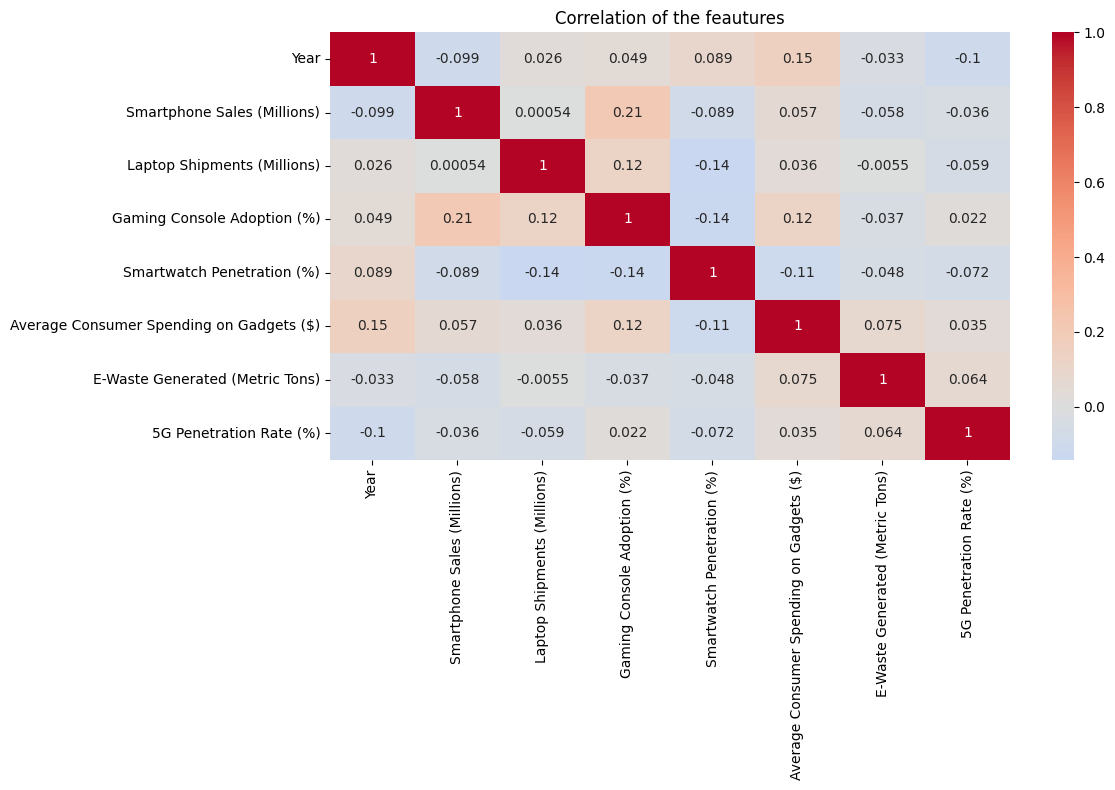

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
correlation_matrix = df.drop('Country', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap= 'coolwarm', center= 0)
plt.title('Correlation of the feautures')
plt.tight_layout()
plt.show()

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]),
 [Text(0.0, 0, '0'),
  Text(250.0, 0, '250'),
  Text(500.0, 0, '500'),
  Text(750.0, 0, '750'),
  Text(1000.0, 0, '1000'),
  Text(1250.0, 0, '1250'),
  Text(1500.0, 0, '1500'),
  Text(1750.0, 0, '1750'),
  Text(2000.0, 0, '2000'),
  Text(2250.0, 0, '2250')])

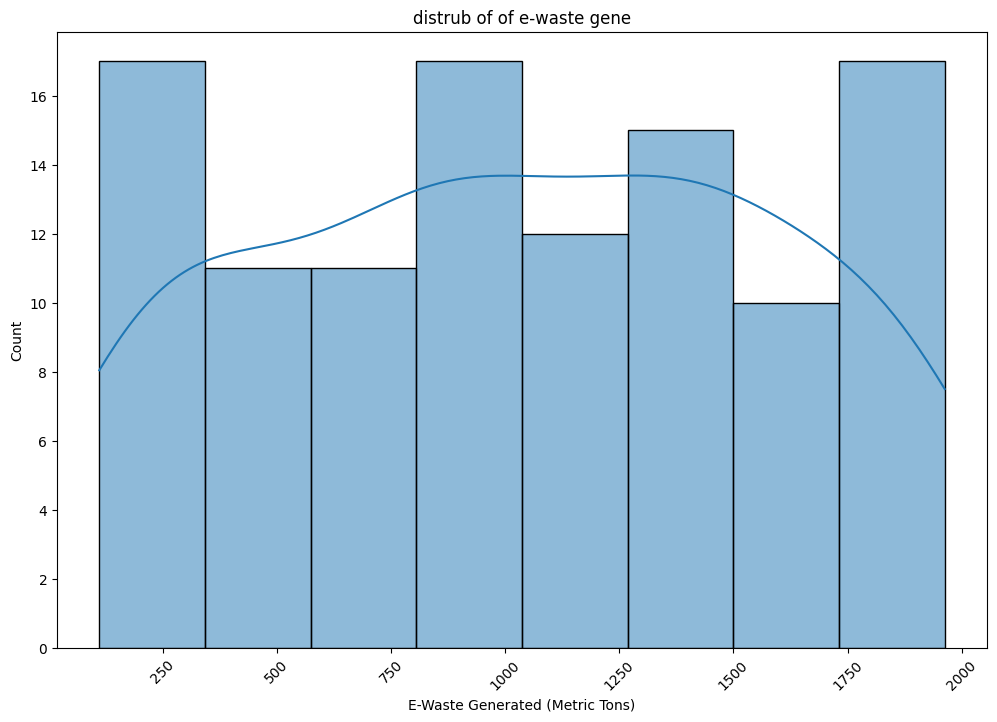

In [25]:
plt.figure(figsize=(12, 8))
sns.histplot(df['E-Waste Generated (Metric Tons)'], kde= True)
plt.title('distrub of of e-waste gene')
plt.xticks(rotation= 45)

In [26]:
X = df.drop(['E-Waste Generated (Metric Tons)','Country'], axis= 1)
y = df['E-Waste Generated (Metric Tons)']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
mlflow.set_tracking_uri("file:///Users/jennifertran/Desktop/Spring PT 2 2025/mlops/labs/mlruns")
mlflow.set_experiment("lab2")

<Experiment: artifact_location='/Users/jennifertran/Desktop/Spring PT 2 2025/mlops/labs/mlruns/1', creation_time=1742883344448, experiment_id='1', last_update_time=1742883344448, lifecycle_stage='active', name='lab2', tags={}>

In [37]:
def objective(params):
    with mlflow.start_run():
        model_type = params['type']
        del params['type']
        
        # Create model based on type
        if model_type == 'lr':
            model = LinearRegression(**params)
        elif model_type == 'dt':
            model = DecisionTreeRegressor(**params)
        elif model_type == 'rf':
            model = RandomForestRegressor(**params)
        else:
            return 0
        
        # Fit the model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions on train and test sets
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        # Calculate RMSE for both sets
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        # Calculate R2 scores
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        # Log everything with MLflow
        mlflow.set_tag("Model", model_type)
        mlflow.log_params(params)
        mlflow.log_metric("train_rmse", train_rmse)
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("train_r2", train_r2)
        mlflow.log_metric("test_r2", test_r2)
        mlflow.sklearn.log_model(model, artifact_path='models')
        
        return {'loss': test_rmse, 'status': STATUS_OK}

# Define the search space
search_space = hp.choice('model_type', [
    {
        'type': 'lr'  # Linear Regression has no hyperparameters to tune
    },
    {
        'type': 'dt',
        'criterion': hp.choice('dt_criterion', ['squared_error', 'friedman_mse', 'absolute_error']),
        'max_depth': hp.choice('dt_max_depth', [None, hp.randint('dt_max_depth_int', 1, 10)]),
        'min_samples_split': hp.randint('dt_min_samples_split', 2, 10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2, X_train.shape[1]),
        'criterion': hp.choice('rf_criterion', ['squared_error', 'absolute_error'])
    }
])

# Set up the optimization
algo = tpe.suggest
trials = Trials()

# Run the optimization
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=algo,
    max_evals=32,
    trials=trials
)

  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/03/24 23:50:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



  3%|▎         | 1/32 [00:02<01:18,  2.52s/trial, best loss: 652.7727403417424]

2025/03/24 23:50:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



  6%|▋         | 2/32 [00:04<01:10,  2.36s/trial, best loss: 652.7727403417424]

2025/03/24 23:51:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



  9%|▉         | 3/32 [00:06<01:06,  2.28s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 12%|█▎        | 4/32 [00:08<00:58,  2.10s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 16%|█▌        | 5/32 [00:10<00:53,  1.97s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 19%|█▉        | 6/32 [00:12<00:48,  1.87s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 22%|██▏       | 7/32 [00:14<00:48,  1.94s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 25%|██▌       | 8/32 [00:16<00:45,  1.89s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 28%|██▊       | 9/32 [00:17<00:41,  1.83s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 31%|███▏      | 10/32 [00:19<00:38,  1.77s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 34%|███▍      | 11/32 [00:21<00:39,  1.88s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 38%|███▊      | 12/32 [00:23<00:36,  1.82s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 41%|████      | 13/32 [00:24<00:34,  1.80s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 44%|████▍     | 14/32 [00:27<00:34,  1.91s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 47%|████▋     | 15/32 [00:28<00:31,  1.85s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 50%|█████     | 16/32 [00:30<00:29,  1.82s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 53%|█████▎    | 17/32 [00:32<00:28,  1.91s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 56%|█████▋    | 18/32 [00:34<00:27,  1.96s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 59%|█████▉    | 19/32 [00:36<00:25,  1.95s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 62%|██████▎   | 20/32 [00:38<00:23,  1.98s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 66%|██████▌   | 21/32 [00:40<00:21,  1.93s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 69%|██████▉   | 22/32 [00:42<00:18,  1.88s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 72%|███████▏  | 23/32 [00:45<00:19,  2.13s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 75%|███████▌  | 24/32 [00:46<00:16,  2.05s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 78%|███████▊  | 25/32 [00:48<00:14,  2.03s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 81%|████████▏ | 26/32 [00:50<00:12,  2.02s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 84%|████████▍ | 27/32 [00:52<00:09,  1.88s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 88%|████████▊ | 28/32 [00:54<00:07,  1.82s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 91%|█████████ | 29/32 [00:55<00:05,  1.77s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 94%|█████████▍| 30/32 [00:57<00:03,  1.70s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 97%|█████████▋| 31/32 [00:58<00:01,  1.68s/trial, best loss: 648.2842657918058]

2025/03/24 23:51:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



100%|██████████| 32/32 [01:00<00:00,  1.89s/trial, best loss: 648.2842657918058]


In [38]:
experiments = mlflow.search_experiments()
import os
import os
experiments

[<Experiment: artifact_location='/Users/jennifertran/Desktop/Spring PT 2 2025/mlops/labs/mlruns/1', creation_time=1742883344448, experiment_id='1', last_update_time=1742883344448, lifecycle_stage='active', name='lab2', tags={}>]

In [47]:
import os

os.environ['MLFLOW_TRACKING_URI'] = 'http://127.0.0.1:5020'


In [48]:
best_run_id = "cc531d7edebe48ac844a9d3f2a271f00" 
model_uri = f"runs:/{best_run_id}/model"
mlflow.register_model(model_uri, "tech_gadget_ewaste_predictor")

Registered model 'tech_gadget_ewaste_predictor' already exists. Creating a new version of this model...
Created version '4' of model 'tech_gadget_ewaste_predictor'.


<ModelVersion: aliases=[], creation_timestamp=1742885710657, current_stage='None', description=None, last_updated_timestamp=1742885710657, name='tech_gadget_ewaste_predictor', run_id='cc531d7edebe48ac844a9d3f2a271f00', run_link=None, source=('/Users/jennifertran/Desktop/Spring PT 2 '
 '2025/mlops/labs/mlruns/1/cc531d7edebe48ac844a9d3f2a271f00/artifacts/model'), status='READY', status_message=None, tags={}, user_id=None, version=4>

In [50]:
best_model = mlflow.sklearn.load_model(model_uri)
test_predictions = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

OSError: No such file or directory: '/Users/jennifertran/Desktop/Spring PT 2 2025/mlops/labs/mlruns/1/cc531d7edebe48ac844a9d3f2a271f00/artifacts/model'

In [141]:
with mlflow.start_run():
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.set_tag("run_type", "test_evaluation")

Successfully registered model 'tech_gadget_ewaste_predictor'.
Created version '1' of model 'tech_gadget_ewaste_predictor'.
